In [15]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
%matplotlib inline
import itertools
import warnings
plt.style.use('ggplot')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

In [20]:
# reads the excel file into the notebook
df = pd.read_excel('C:\\Users\\prajn\\Downloads\\air+quality\\AirQualityUCI.xlsx')

# prints the first 5 values
print(df.head())  

        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1 2004-03-10  19:00:00     2.0      1292.25       112   9.397165   
2 2004-03-10  20:00:00     2.2      1402.00        88   8.997817   
3 2004-03-10  21:00:00     2.2      1375.50        80   9.228796   
4 2004-03-10  22:00:00     1.6      1272.25        51   6.518224   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1045.50    166.0       1056.25    113.0       1692.00      1267.50   
1         954.75    103.0       1173.75     92.0       1558.75       972.25   
2         939.25    131.0       1140.00    114.0       1554.50      1074.00   
3         948.25    172.0       1092.00    122.0       1583.75      1203.25   
4         835.50    131.0       1205.00    116.0       1490.00      1110.00   

       T         RH        AH  
0  13.60  48.875001  0.757754  
1  13.30  47.700000  0.725487  
2  11.90  53.975000 

In [21]:
# Identify rows with missing values in the DataFrame 'df'
rows_with_missing_values = df[df.isnull().any(axis=1)]

print("Rows with Missing Values:")
print(rows_with_missing_values)

# Drop rows with missing values and assign the result to 'rows_with_missing_values' variable
rows_with_missing_values = df[df.isnull().any(axis=1)].dropna() 

Rows with Missing Values:
Empty DataFrame
Columns: [Date, Time, CO(GT), PT08.S1(CO), NMHC(GT), C6H6(GT), PT08.S2(NMHC), NOx(GT), PT08.S3(NOx), NO2(GT), PT08.S4(NO2), PT08.S5(O3), T, RH, AH]
Index: []


In [22]:
# Convert 'Date' and 'Time' columns to a single 'Timestamp' column of datetime type
df['Timestamp'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Drop the 'Date' and 'Time' columns from the DataFrame, keeping only the 'Timestamp'
df = df.drop(['Date', 'Time'], axis=1)

print(df.head())

   CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0     2.6      1360.00       150  11.881723        1045.50    166.0   
1     2.0      1292.25       112   9.397165         954.75    103.0   
2     2.2      1402.00        88   8.997817         939.25    131.0   
3     2.2      1375.50        80   9.228796         948.25    172.0   
4     1.6      1272.25        51   6.518224         835.50    131.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)      T         RH  \
0       1056.25    113.0       1692.00      1267.50  13.60  48.875001   
1       1173.75     92.0       1558.75       972.25  13.30  47.700000   
2       1140.00    114.0       1554.50      1074.00  11.90  53.975000   
3       1092.00    122.0       1583.75      1203.25  11.00  60.000000   
4       1205.00    116.0       1490.00      1110.00  11.15  59.575001   

         AH           Timestamp  
0  0.757754 2004-03-10 18:00:00  
1  0.725487 2004-03-10 19:00:00  
2  0.750239 2004-03-10 20:00:00 

In [23]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set the 'Timestamp' column as the index of the DataFrame
df = df.set_index('Timestamp')

# Resample the DataFrame to a daily frequency, aggregating with the mean
df_resampled = df.resample('D').mean()

print(df_resampled)

               CO(GT)  PT08.S1(CO)    NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  \
Timestamp                                                                  
2004-03-10   1.966667  1316.500000   86.500000   8.460790     912.250000   
2004-03-11  -6.187500  1244.062500  104.500000   7.989058     851.802083   
2004-03-12 -14.095833  1281.562500  141.500000  12.129509    1008.229167   
2004-03-13  -5.750000  1330.555556  139.250000  10.922887     992.822917   
2004-03-14  -5.966667  1360.927083  116.958333   9.631442     943.854167   
...               ...          ...         ...        ...            ...   
2005-03-31   1.387500  1007.989583 -200.000000   5.226496     749.302083   
2005-04-01  -7.270833   903.142361 -200.000000   3.416610     662.871528   
2005-04-02   0.854167   890.895833 -200.000000   2.527522     616.197917   
2005-04-03   1.141667   981.152778 -200.000000   4.318307     714.579861   
2005-04-04 -11.393333  1090.400000 -200.000000   8.435233     862.133333   

           

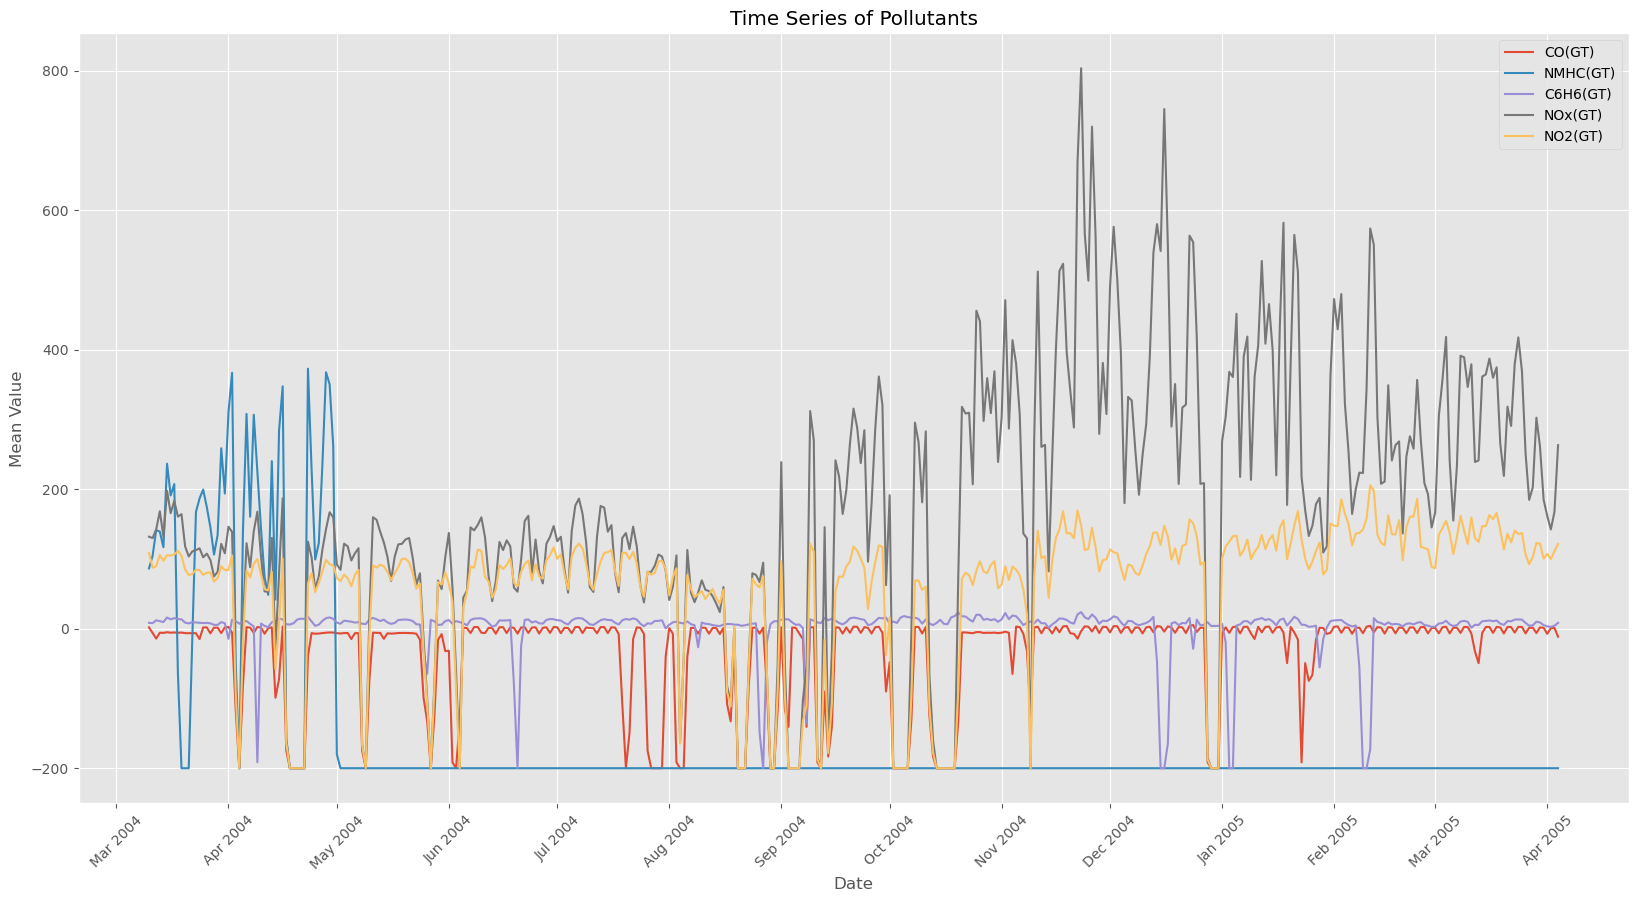

In [24]:
# Convert the index of df_resampled to datetime format and assign it to the 'Timestamp' column
df_resampled['Timestamp'] = pd.to_datetime(df_resampled.index)

# Set up a figure with a specified size
plt.figure(figsize=(20, 10))

# Plot the time series for each pollutant
plt.plot(df_resampled['Timestamp'], df_resampled['CO(GT)'], label='CO(GT)')
plt.plot(df_resampled['Timestamp'], df_resampled['NMHC(GT)'], label='NMHC(GT)')
plt.plot(df_resampled['Timestamp'], df_resampled['C6H6(GT)'], label='C6H6(GT)')
plt.plot(df_resampled['Timestamp'], df_resampled['NOx(GT)'], label='NOx(GT)')
plt.plot(df_resampled['Timestamp'], df_resampled['NO2(GT)'], label='NO2(GT)')

# Set the title, x-axis label, and y-axis label
plt.title('Time Series of Pollutants')
plt.xlabel('Date')
plt.ylabel('Mean Value')
plt.legend()

# Configure x-axis to show major ticks for each month and format as month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

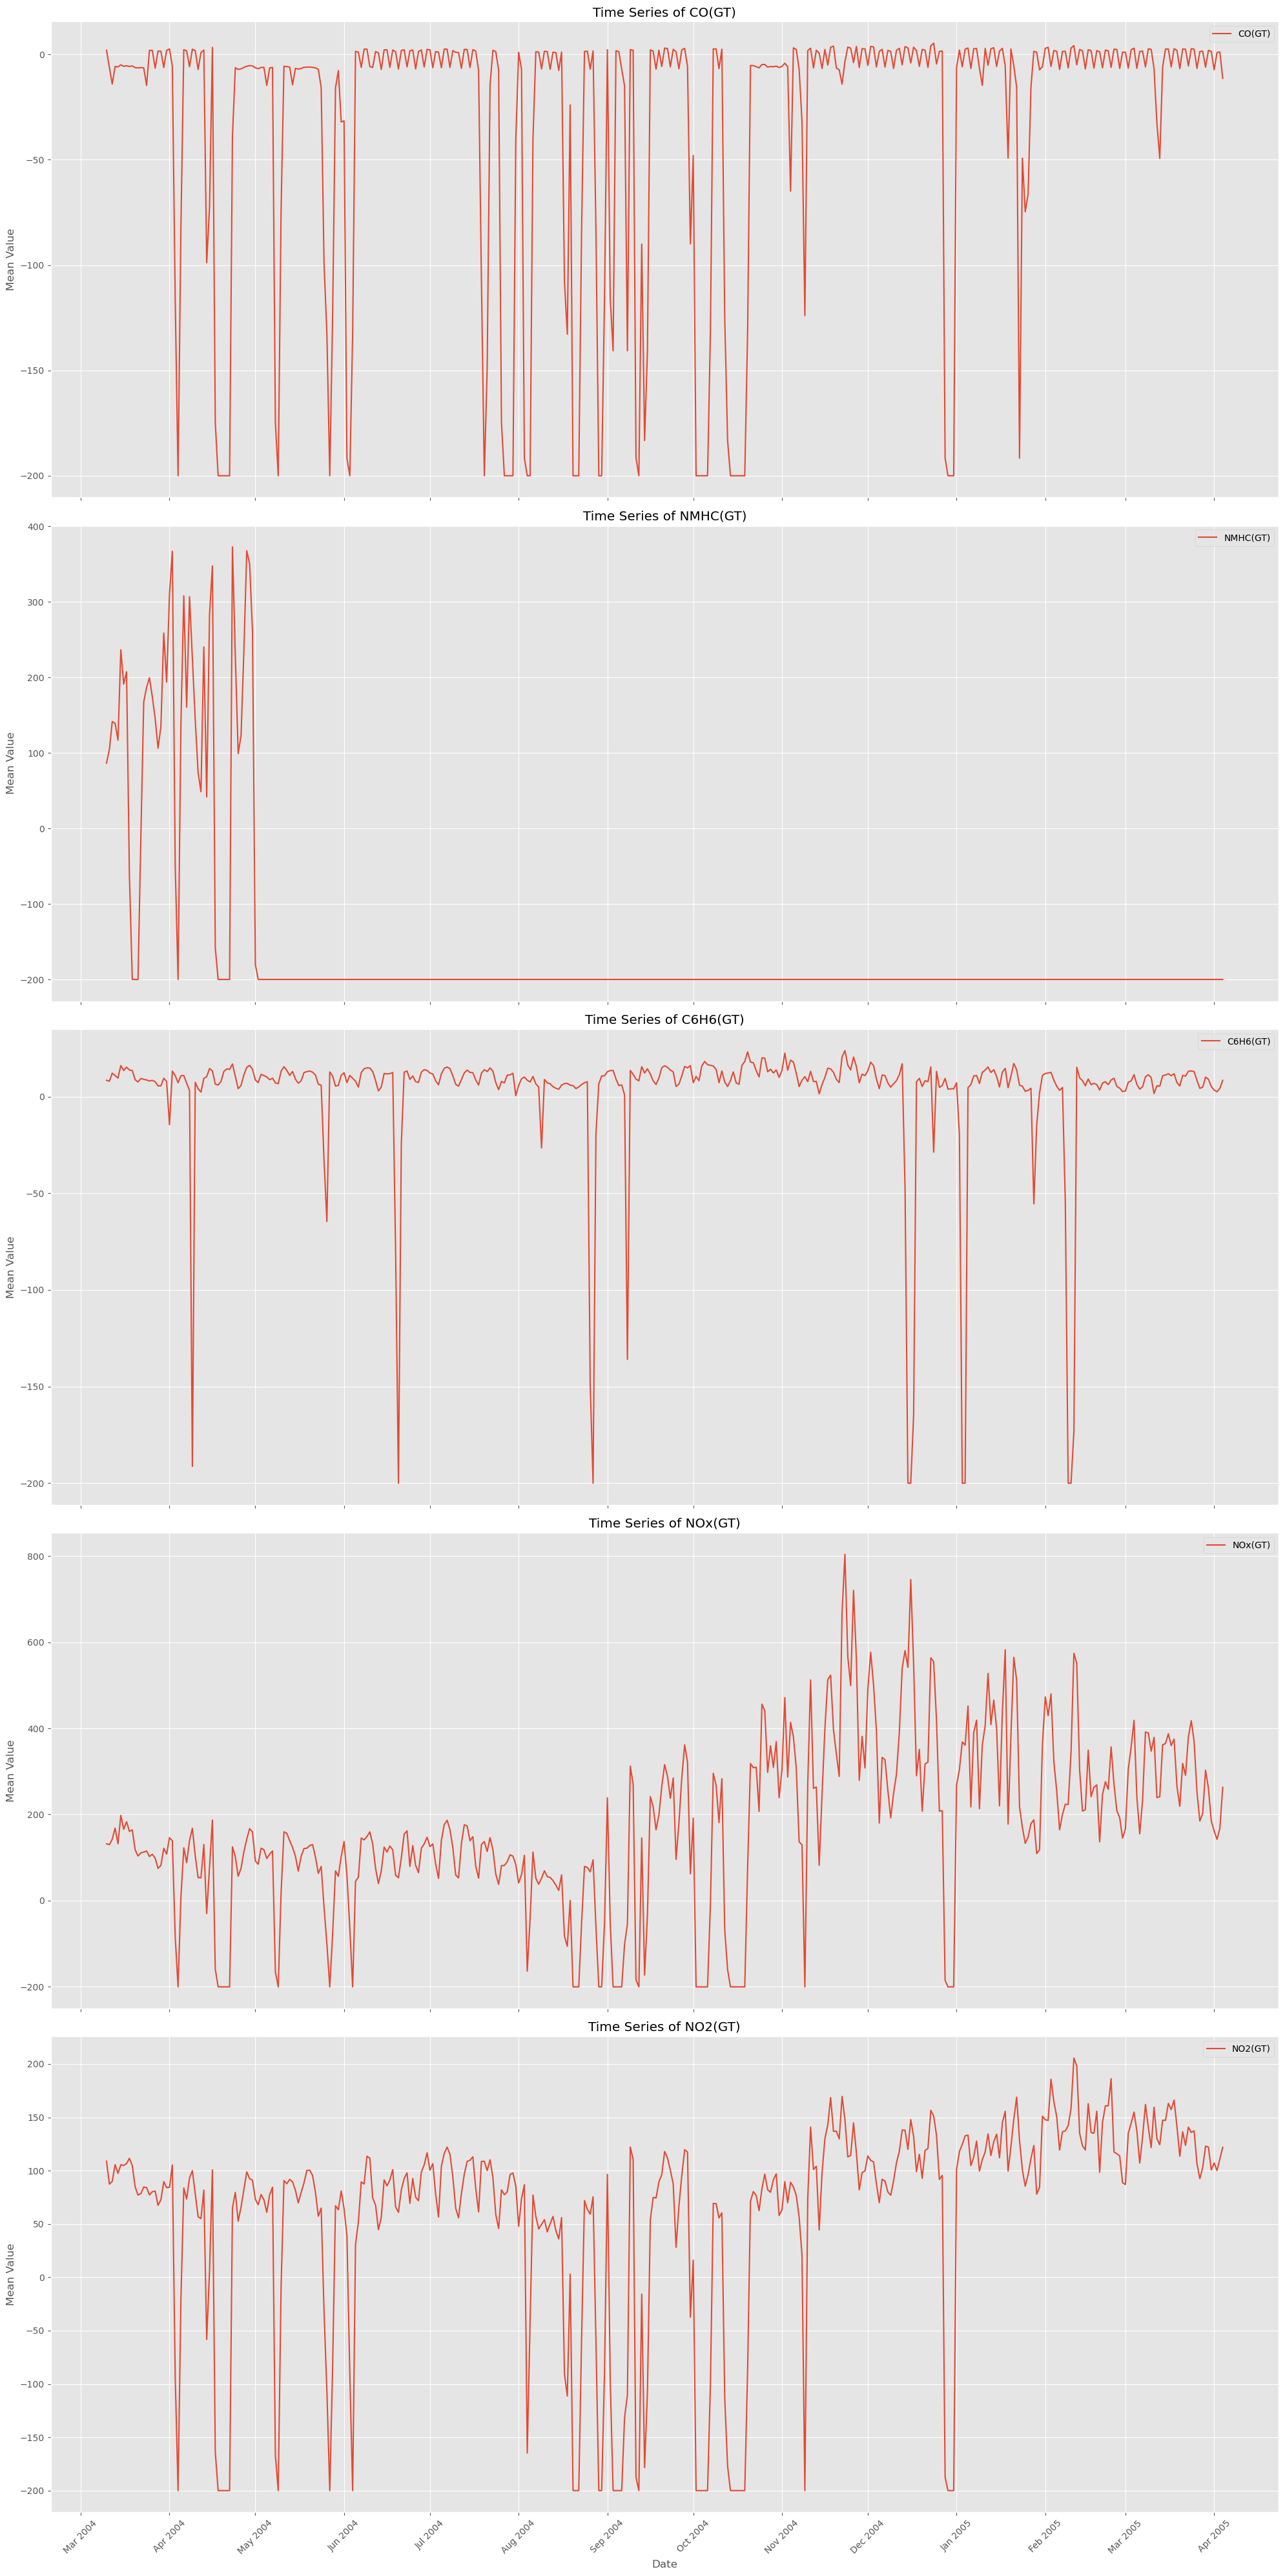

In [25]:
# List of pollutants to visualize
pollutants = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# Create subplots with the number of rows equal to the number of pollutants
fig, axes = plt.subplots(nrows=len(pollutants), figsize=(20, 8 * len(pollutants)), sharex=True)

# Loop through each pollutant and plot its time series on a separate subplot
for i, pollutant in enumerate(pollutants):
    axes[i].plot(df_resampled['Timestamp'], df_resampled[pollutant], label=pollutant)
    axes[i].set_title(f'Time Series of {pollutant}')
    axes[i].set_ylabel('Mean Value')
    axes[i].grid(True)
    axes[i].legend()

axes[-1].xaxis.set_major_locator(mdates.MonthLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xlabel('Date')
plt.xticks(rotation=45)

# Adjust layout to prevent subplots from overlapping
plt.tight_layout()
plt.show()


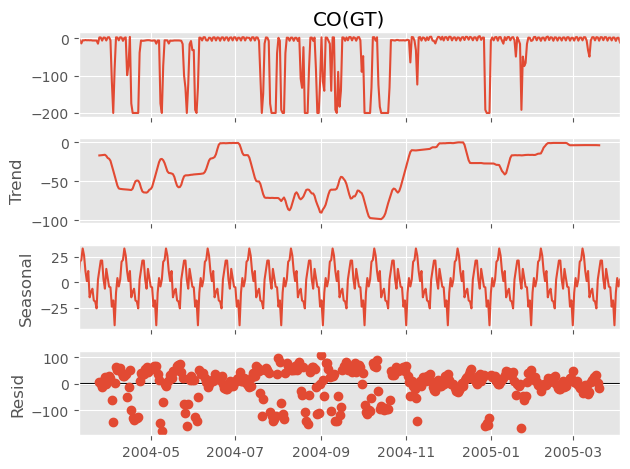

In [26]:
# Perform seasonal decomposition on the 'CO(GT)' time series using an additive model
result = seasonal_decompose(df_resampled['CO(GT)'], model='additive', period=30)  

result.plot()
plt.show()

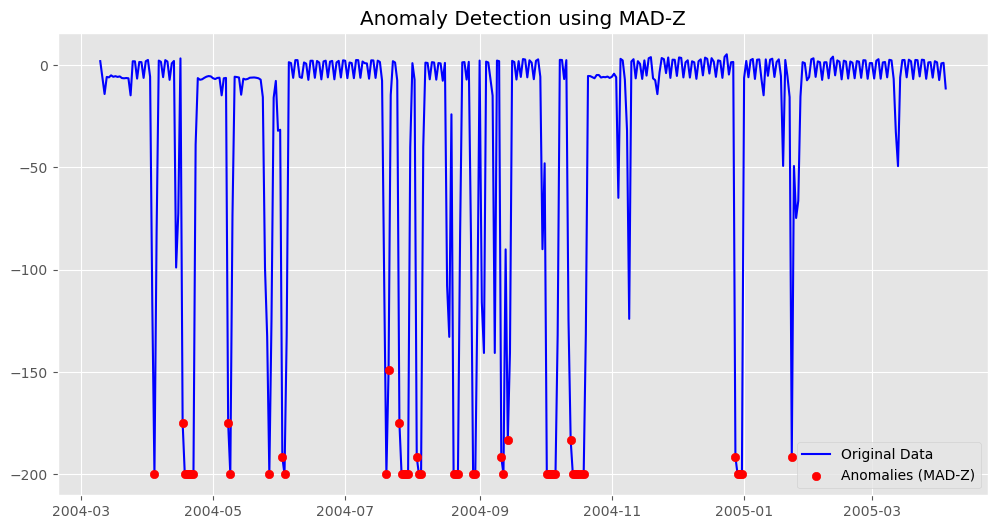

In [27]:
# Ensure numeric values
df_resampled['CO(GT)'] = pd.to_numeric(df_resampled['CO(GT)'], errors='coerce')  

# Calculate median absolute deviation (MAD)
mad = np.median(np.abs(df_resampled['CO(GT)'].dropna() - df_resampled['CO(GT)'].dropna().median()))

# Calculate modified z-scores
mad_z_scores = 0.6745 * (df_resampled['CO(GT)'].dropna() - df_resampled['CO(GT)'].dropna().median()) / mad

# Set a threshold for anomaly detection (adjust as needed)
threshold = 12
anomalies_mad_z = mad_z_scores.abs() > threshold

# Plot the time series with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['CO(GT)'], label='Original Data',color='blue')
plt.scatter(anomalies_mad_z[anomalies_mad_z].index, df_resampled['CO(GT)'][anomalies_mad_z], color='red', label='Anomalies (MAD-Z)', zorder=5)
plt.legend()
plt.title('Anomaly Detection using MAD-Z')
plt.show()


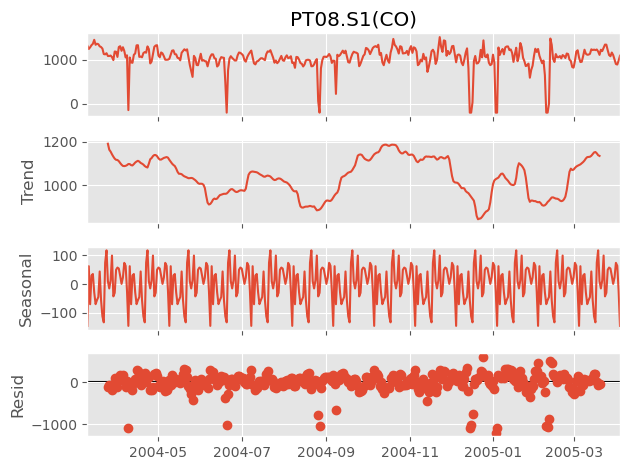

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_resampled['PT08.S1(CO)'], model='additive', period=30)  

result.plot()
plt.show()

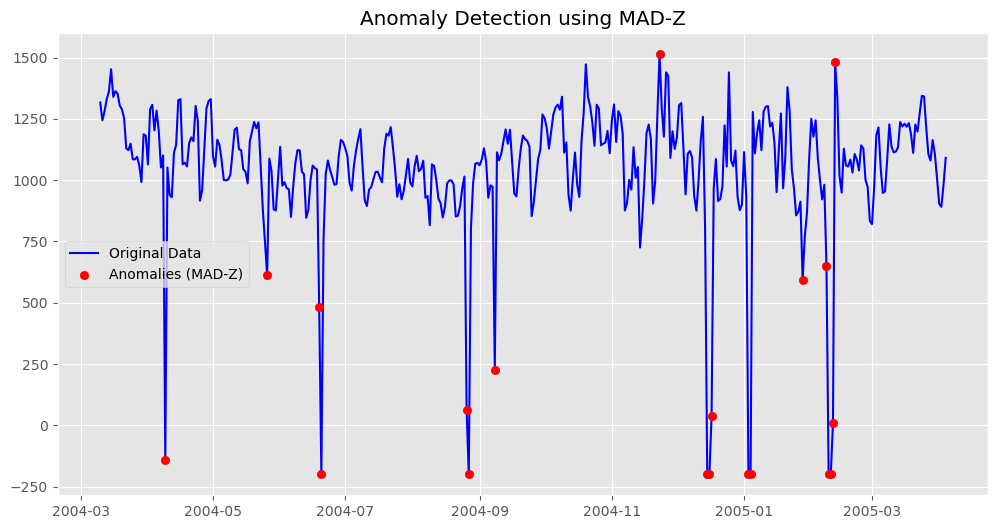

In [29]:
df_resampled['PT08.S1(CO)'] = pd.to_numeric(df_resampled['PT08.S1(CO)'], errors='coerce')  # Ensure numeric values

# Calculate median absolute deviation (MAD)
mad = np.median(np.abs(df_resampled['PT08.S1(CO)'].dropna() - df_resampled['PT08.S1(CO)'].dropna().median()))

# Calculate modified z-scores
mad_z_scores = 0.6745 * (df_resampled['PT08.S1(CO)'].dropna() - df_resampled['PT08.S1(CO)'].dropna().median()) / mad
# 0.6745
# Set a threshold for anomaly detection (adjust as needed)
threshold = 2.5
anomalies_mad_z = mad_z_scores.abs() > threshold

# Plot the time series with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['PT08.S1(CO)'], label='Original Data',color='blue')
plt.scatter(anomalies_mad_z[anomalies_mad_z].index, df_resampled['PT08.S1(CO)'][anomalies_mad_z], color='red', label='Anomalies (MAD-Z)', zorder=5)
plt.legend()
plt.title('Anomaly Detection using MAD-Z')
plt.show()

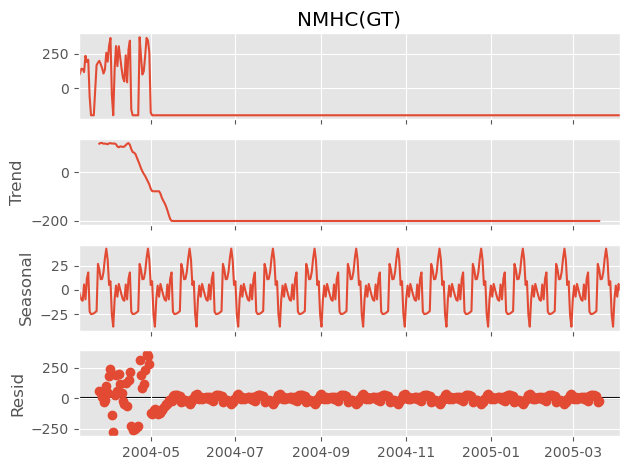

In [30]:
result = seasonal_decompose(df_resampled['NMHC(GT)'], model='additive', period=30)  

result.plot()
plt.show()

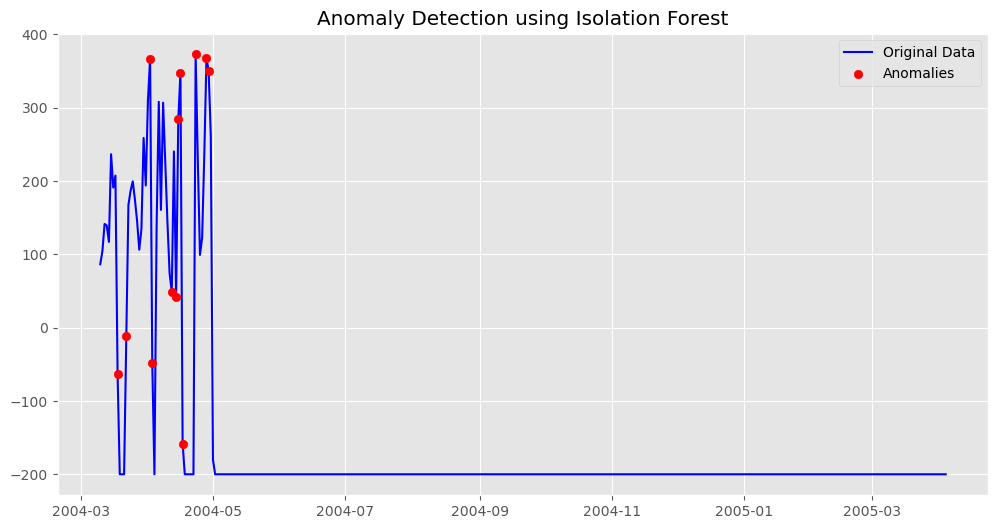

In [31]:
df_resampled['NMHC(GT)'] = pd.to_numeric(df_resampled['NMHC(GT)'], errors='coerce')  # Ensure numeric values

# Prepare data
data = df_resampled[['NMHC(GT)']].dropna()

# Train Isolation Forest model
model = IsolationForest(contamination=0.03)  # Adjust the contamination parameter
model.fit(data)

# Predict anomalies
anomalies = model.predict(data) == -1

# Plot the time series with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['NMHC(GT)'], label='Original Data', color='blue')
plt.scatter(data.index[anomalies], data[anomalies], color='red', label='Anomalies', zorder=5)
plt.legend()
plt.title('Anomaly Detection using Isolation Forest')
plt.show()



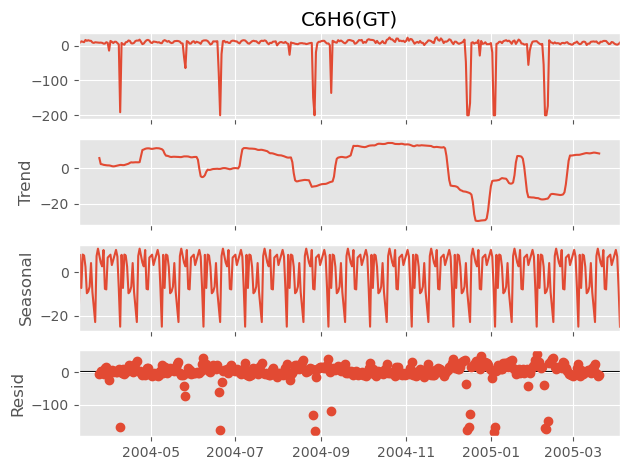

In [32]:
result = seasonal_decompose(df_resampled['C6H6(GT)'], model='additive', period=30)  

result.plot()
plt.show()

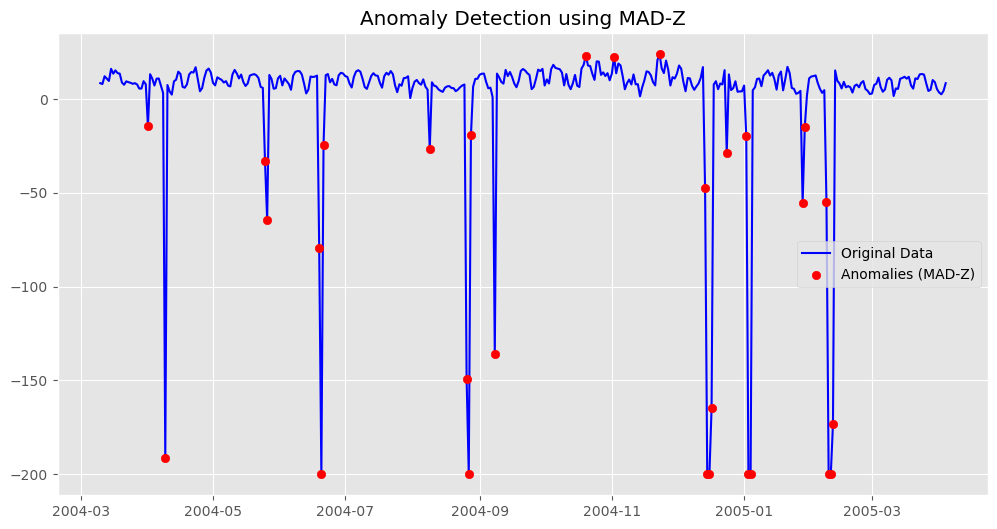

In [33]:
df_resampled['C6H6(GT)'] = pd.to_numeric(df_resampled['C6H6(GT)'], errors='coerce')  # Ensure numeric values

# Calculate median absolute deviation (MAD)
mad = np.median(np.abs(df_resampled['C6H6(GT)'].dropna() - df_resampled['C6H6(GT)'].dropna().median()))

# Calculate modified z-scores
mad_z_scores = 0.6745 * (df_resampled['C6H6(GT)'].dropna() - df_resampled['C6H6(GT)'].dropna().median()) / mad
# 0.6745
# Set a threshold for anomaly detection (adjust as needed)
threshold = 2.5
anomalies_mad_z = mad_z_scores.abs() > threshold

# Plot the time series with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['C6H6(GT)'], label='Original Data',color='blue')
plt.scatter(anomalies_mad_z[anomalies_mad_z].index, df_resampled['C6H6(GT)'][anomalies_mad_z], color='red', label='Anomalies (MAD-Z)', zorder=5)
plt.legend()
plt.title('Anomaly Detection using MAD-Z')
plt.show()

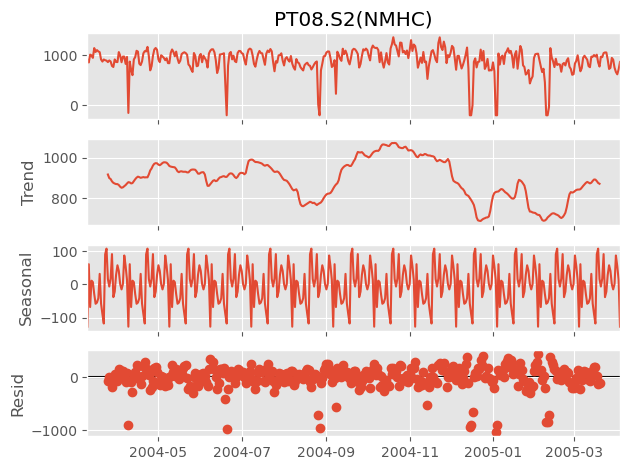

In [34]:
result = seasonal_decompose(df_resampled['PT08.S2(NMHC)'], model='additive', period=30)  

result.plot()
plt.show()

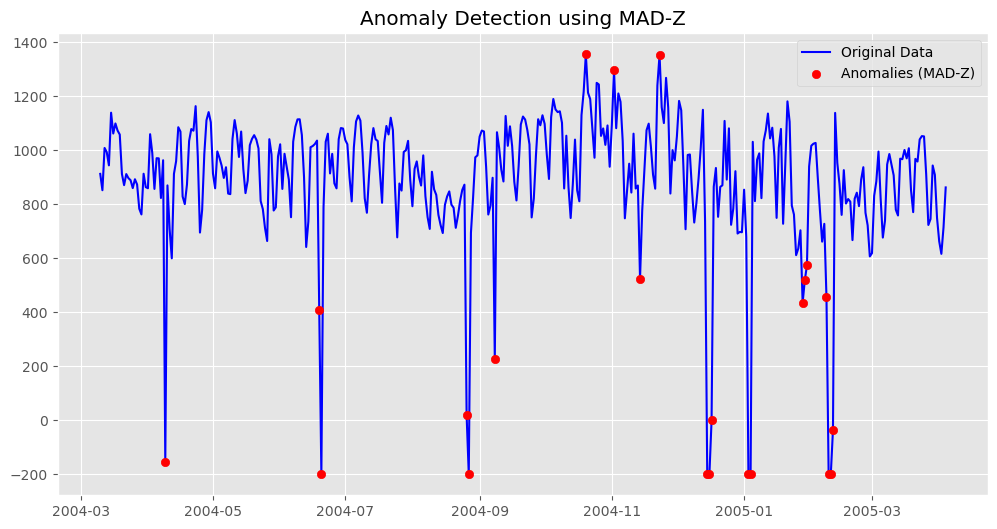

In [35]:
df_resampled['PT08.S2(NMHC)'] = pd.to_numeric(df_resampled['PT08.S2(NMHC)'], errors='coerce')  # Ensure numeric values

# Calculate median absolute deviation (MAD)
mad = np.median(np.abs(df_resampled['PT08.S2(NMHC)'].dropna() - df_resampled['PT08.S2(NMHC)'].dropna().median()))

# Calculate modified z-scores
mad_z_scores = 0.6745 * (df_resampled['PT08.S2(NMHC)'].dropna() - df_resampled['PT08.S2(NMHC)'].dropna().median()) / mad
# 0.6745
# Set a threshold for anomaly detection (adjust as needed)
threshold = 2
anomalies_mad_z = mad_z_scores.abs() > threshold

# Plot the time series with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['PT08.S2(NMHC)'], label='Original Data',color='blue')
plt.scatter(anomalies_mad_z[anomalies_mad_z].index, df_resampled['PT08.S2(NMHC)'][anomalies_mad_z], color='red', label='Anomalies (MAD-Z)', zorder=5)
plt.legend()
plt.title('Anomaly Detection using MAD-Z')
plt.show()

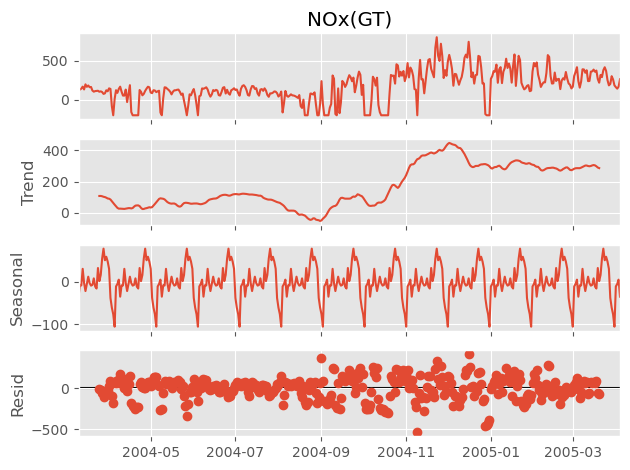

In [36]:
result = seasonal_decompose(df_resampled['NOx(GT)'], model='additive', period=30)  

result.plot()
plt.show()

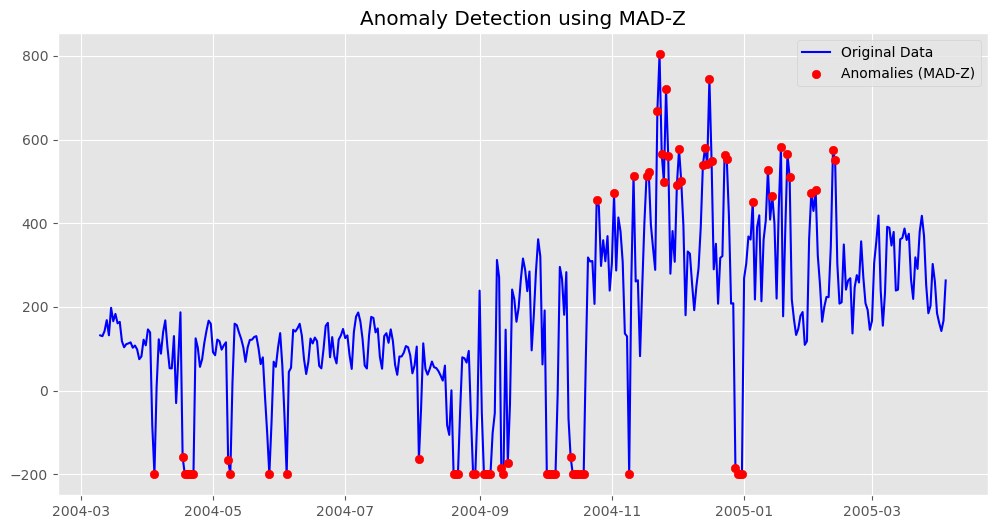

In [39]:
df_resampled['NOx(GT)'] = pd.to_numeric(df_resampled['NOx(GT)'], errors='coerce')  # Ensure numeric values

# Calculate median absolute deviation (MAD)
mad = np.median(np.abs(df_resampled['NOx(GT)'].dropna() - df_resampled['NOx(GT)'].dropna().median()))

# Calculate modified z-scores
mad_z_scores = 0.6745 * (df_resampled['NOx(GT)'].dropna() - df_resampled['NOx(GT)'].dropna().median()) / mad
# 0.6745
# Set a threshold for anomaly detection (adjust as needed)
threshold = 2
anomalies_mad_z = mad_z_scores.abs() > threshold

# Plot the time series with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['NOx(GT)'], label='Original Data',color='blue')
plt.scatter(anomalies_mad_z[anomalies_mad_z].index, df_resampled['NOx(GT)'][anomalies_mad_z], color='red', label='Anomalies (MAD-Z)', zorder=5)
plt.legend()
plt.title('Anomaly Detection using MAD-Z')
plt.show()

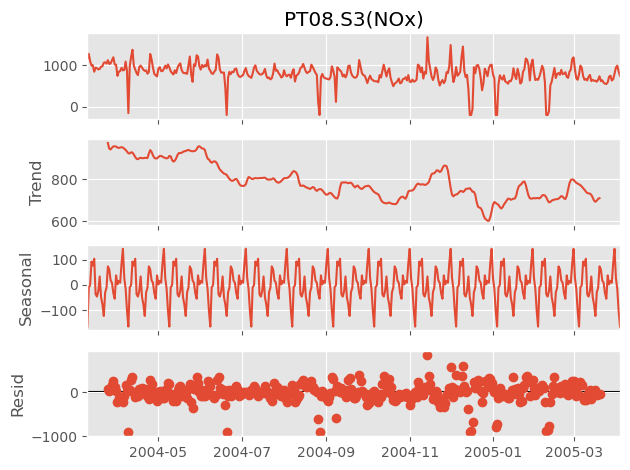

In [40]:
result = seasonal_decompose(df_resampled['PT08.S3(NOx)'], model='additive', period=30)  

result.plot()
plt.show()

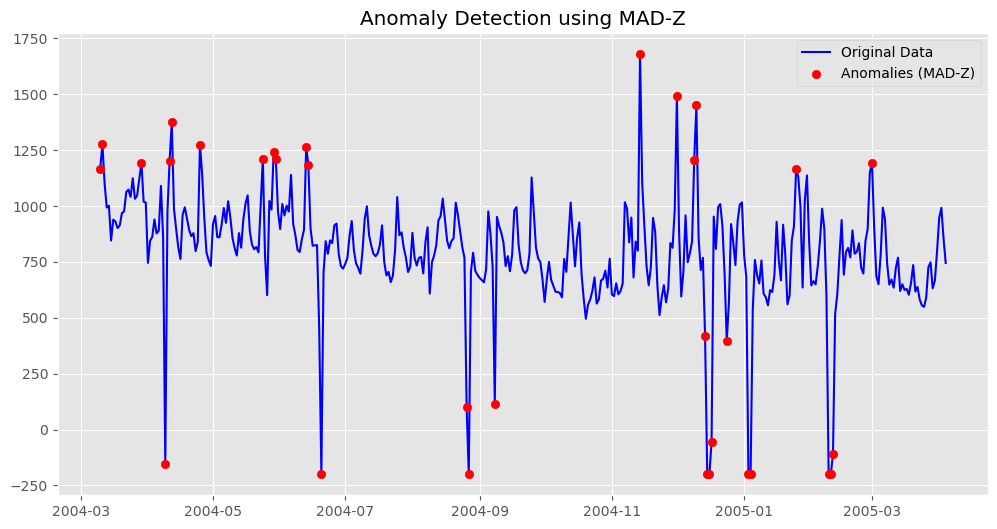

In [41]:
df_resampled['PT08.S3(NOx)'] = pd.to_numeric(df_resampled['PT08.S3(NOx)'], errors='coerce')  # Ensure numeric values

# Calculate median absolute deviation (MAD)
mad = np.median(np.abs(df_resampled['PT08.S3(NOx)'].dropna() - df_resampled['PT08.S3(NOx)'].dropna().median()))

# Calculate modified z-scores
mad_z_scores = 0.6745 * (df_resampled['PT08.S3(NOx)'].dropna() - df_resampled['PT08.S3(NOx)'].dropna().median()) / mad
# 0.6745
# Set a threshold for anomaly detection (adjust as needed)
threshold = 2
anomalies_mad_z = mad_z_scores.abs() > threshold

# Plot the time series with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['PT08.S3(NOx)'], label='Original Data',color='blue')
plt.scatter(anomalies_mad_z[anomalies_mad_z].index, df_resampled['PT08.S3(NOx)'][anomalies_mad_z], color='red', label='Anomalies (MAD-Z)', zorder=5)
plt.legend()
plt.title('Anomaly Detection using MAD-Z')
plt.show()

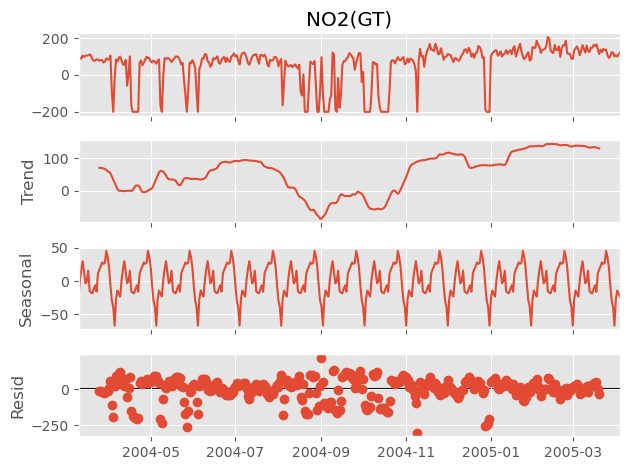

In [42]:
result = seasonal_decompose(df_resampled['NO2(GT)'], model='additive', period=30)  

result.plot()
plt.show()

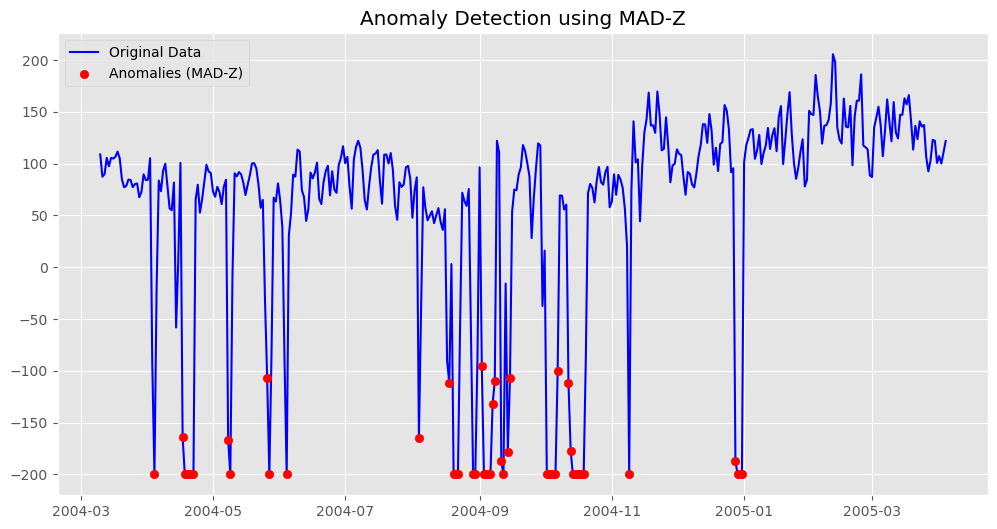

In [43]:
df_resampled['NO2(GT)'] = pd.to_numeric(df_resampled['NO2(GT)'], errors='coerce')  # Ensure numeric values

# Calculate median absolute deviation (MAD)
mad = np.median(np.abs(df_resampled['NO2(GT)'].dropna() - df_resampled['NO2(GT)'].dropna().median()))

# Calculate modified z-scores
mad_z_scores = 0.6745 * (df_resampled['NO2(GT)'].dropna() - df_resampled['NO2(GT)'].dropna().median()) / mad
# 0.6745
# Set a threshold for anomaly detection (adjust as needed)
threshold = 4.5
anomalies_mad_z = mad_z_scores.abs() > threshold

# Plot the time series with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['NO2(GT)'], label='Original Data',color='blue')
plt.scatter(anomalies_mad_z[anomalies_mad_z].index, df_resampled['NO2(GT)'][anomalies_mad_z], color='red', label='Anomalies (MAD-Z)', zorder=5)
plt.legend()
plt.title('Anomaly Detection using MAD-Z')
plt.show()

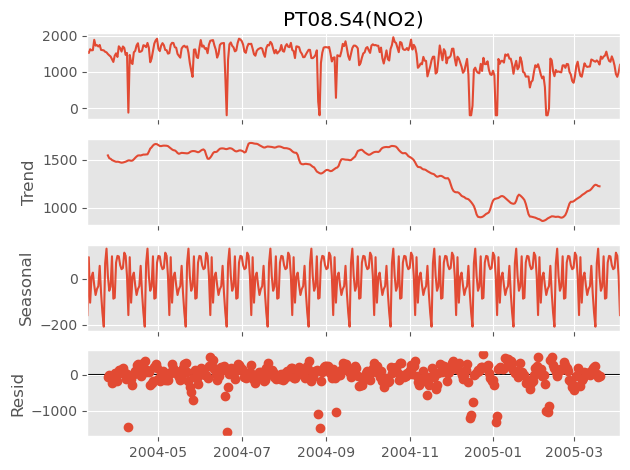

In [44]:
result = seasonal_decompose(df_resampled['PT08.S4(NO2)'], model='additive', period=30)  

result.plot()
plt.show()

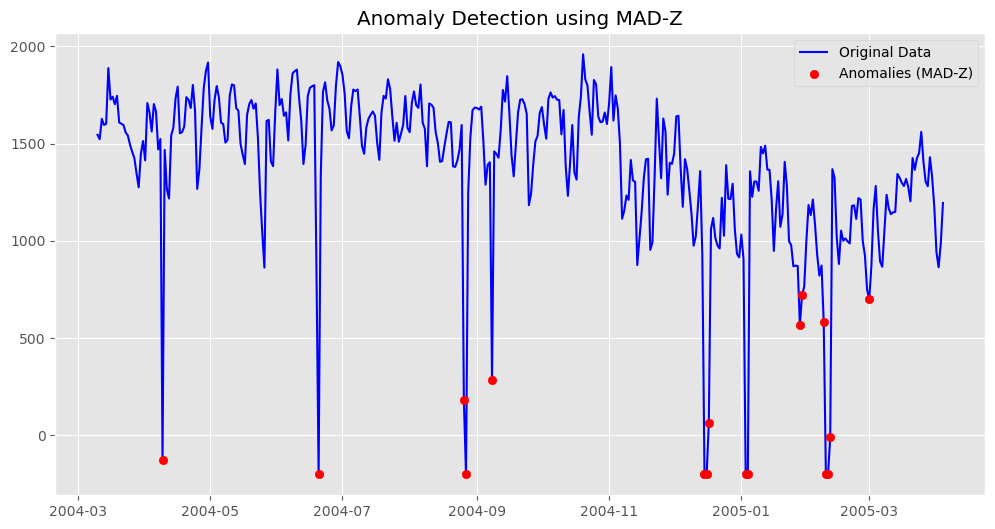

In [45]:
df_resampled['PT08.S4(NO2)'] = pd.to_numeric(df_resampled['PT08.S4(NO2)'], errors='coerce')  # Ensure numeric values

# Calculate median absolute deviation (MAD)
mad = np.median(np.abs(df_resampled['PT08.S4(NO2)'].dropna() - df_resampled['PT08.S4(NO2)'].dropna().median()))

# Calculate modified z-scores
mad_z_scores = 0.6745 * (df_resampled['PT08.S4(NO2)'].dropna() - df_resampled['PT08.S4(NO2)'].dropna().median()) / mad
# 0.6745
# Set a threshold for anomaly detection (adjust as needed)
threshold = 2.5
anomalies_mad_z = mad_z_scores.abs() > threshold

# Plot the time series with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['PT08.S4(NO2)'], label='Original Data',color='blue')
plt.scatter(anomalies_mad_z[anomalies_mad_z].index, df_resampled['PT08.S4(NO2)'][anomalies_mad_z], color='red', label='Anomalies (MAD-Z)', zorder=5)
plt.legend()
plt.title('Anomaly Detection using MAD-Z')
plt.show()

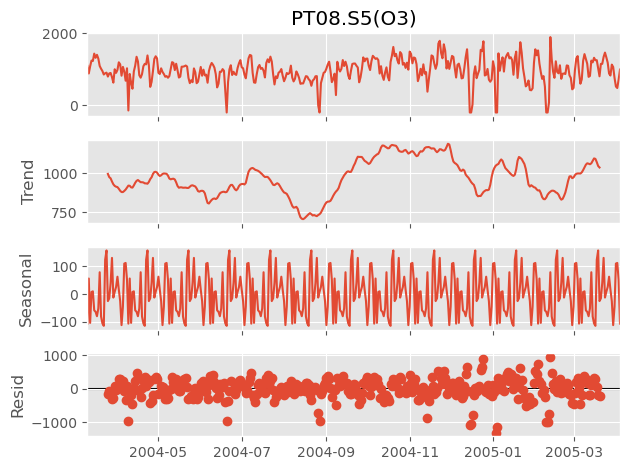

In [46]:
result = seasonal_decompose(df_resampled['PT08.S5(O3)'], model='additive', period=30)  

result.plot()
plt.show()

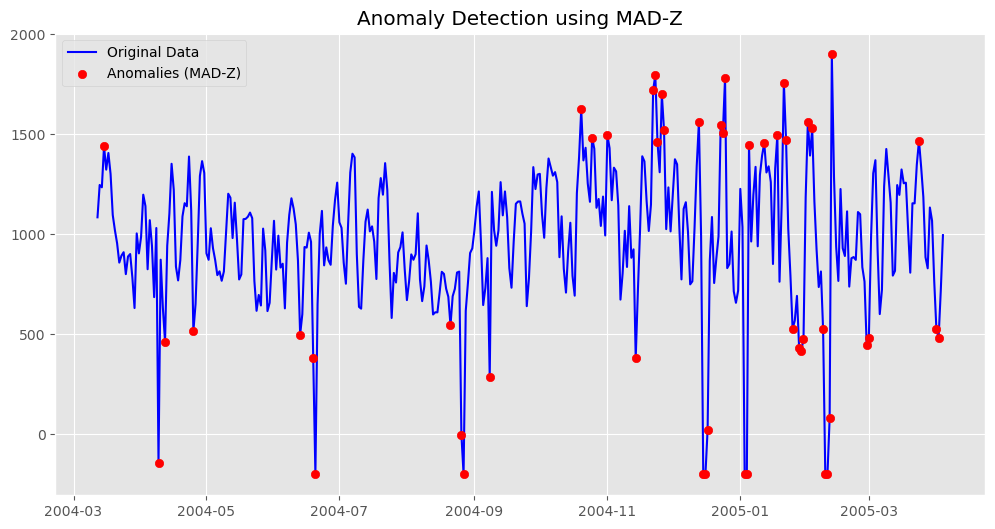

In [64]:
df_resampled['PT08.S5(O3)'] = pd.to_numeric(df_resampled['PT08.S5(O3)'], errors='coerce')  # Ensure numeric values

# Calculate median absolute deviation (MAD)
mad = np.median(np.abs(df_resampled['PT08.S5(O3)'].dropna() - df_resampled['PT08.S5(O3)'].dropna().median()))

# Calculate modified z-scores
mad_z_scores = 0.6745 * (df_resampled['PT08.S5(O3)'].dropna() - df_resampled['PT08.S5(O3)'].dropna().median()) / mad
# 0.6745
# Set a threshold for anomaly detection (adjust as needed)
threshold = 1.5
anomalies_mad_z = mad_z_scores.abs() > threshold

# Plot the time series with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['PT08.S5(O3)'], label='Original Data',color='blue')
plt.scatter(anomalies_mad_z[anomalies_mad_z].index, df_resampled['PT08.S5(O3)'][anomalies_mad_z], color='red', label='Anomalies (MAD-Z)', zorder=5)
plt.legend()
plt.title('Anomaly Detection using MAD-Z')
plt.show()

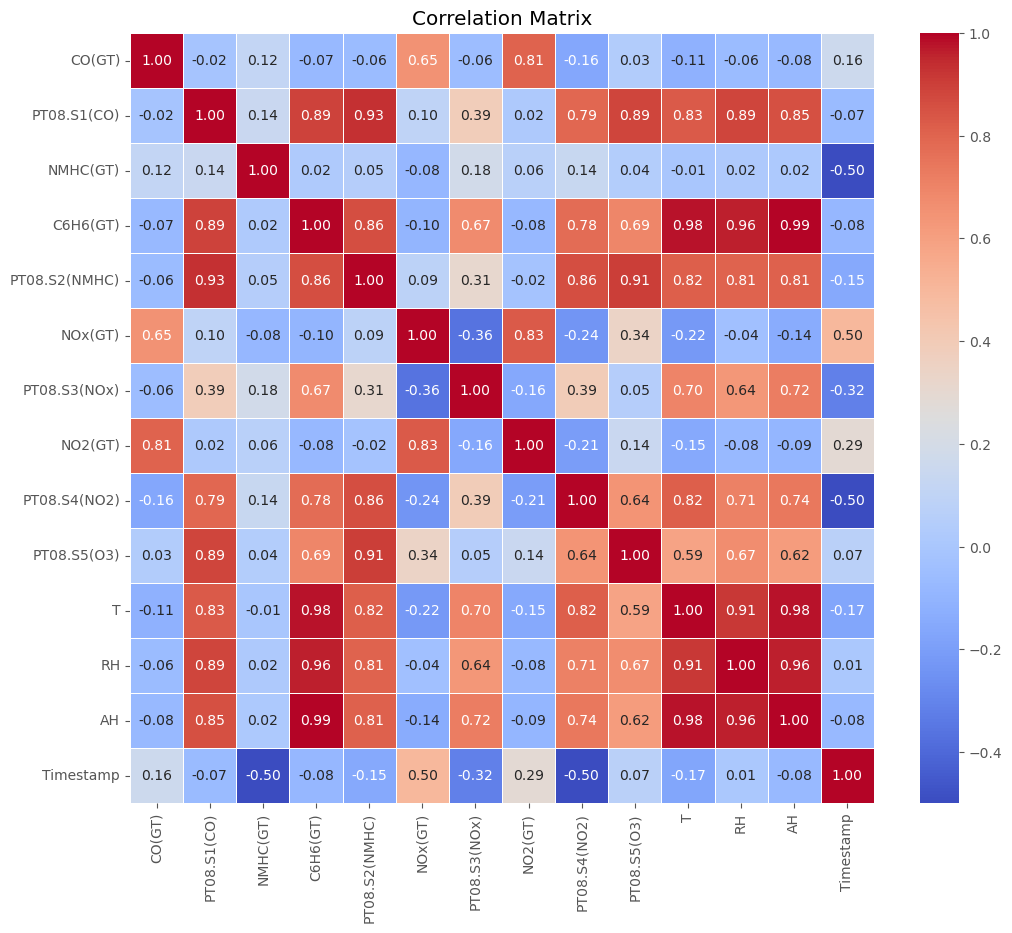

In [48]:
# Calculate the correlation matrix
correlation_matrix = df_resampled.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [49]:
# Create lag features for numeric columns
lag_steps = 1
numeric_columns = df_resampled.select_dtypes(include='number').columns
for column in numeric_columns:
    for i in range(1, lag_steps + 1):
        df_resampled[f'{column}_lag_{i}'] = df_resampled[column].shift(i)

# Create rolling mean features for numeric columns
window_size = 3
for column in numeric_columns:
    df_resampled[f'{column}rm'] = df_resampled[column].rolling(window=window_size).mean()

# Create date-related features
df_resampled['day_of_week'] = df_resampled['Timestamp'].dt.dayofweek
df_resampled['day_of_month'] = df_resampled['Timestamp'].dt.day
df_resampled['month'] = df_resampled['Timestamp'].dt.month
df_resampled['year'] = df_resampled['Timestamp'].dt.year

# Drop rows with NaN values (introduced by lag features)
df_resampled.dropna(inplace=True)

# Print the updated DataFrame
print(df_resampled.head())


               CO(GT)  PT08.S1(CO)    NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  \
Timestamp                                                                  
2004-03-12 -14.095833  1281.562500  141.500000  12.129509    1008.229167   
2004-03-13  -5.750000  1330.555556  139.250000  10.922887     992.822917   
2004-03-14  -5.966667  1360.927083  116.958333   9.631442     943.854167   
2004-03-15  -4.975000  1452.010417  236.625000  16.089946    1138.843750   
2004-03-16  -5.679167  1339.621528  191.125000  13.501465    1061.763889   

               NOx(GT)  PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
Timestamp                                                                     
2004-03-12  142.583333   1101.718750   89.916667   1627.218750  1084.218750   
2004-03-13  168.416667    993.159722  105.583333   1595.621528  1245.781250   
2004-03-14  132.166667   1001.104167   97.458333   1602.187500  1234.177083   
2004-03-15  197.833333    845.562500  105.458333   1888.489583  1439.041

In [50]:
# Perform Augmented Dickey-Fuller test on the 'CO(GT)' time series
ad_fuller_result = adfuller(df_resampled['CO(GT)'])

# Display the results of the Augmented Dickey-Fuller test
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -8.731063678692111
p-value: 3.1907277262416963e-14


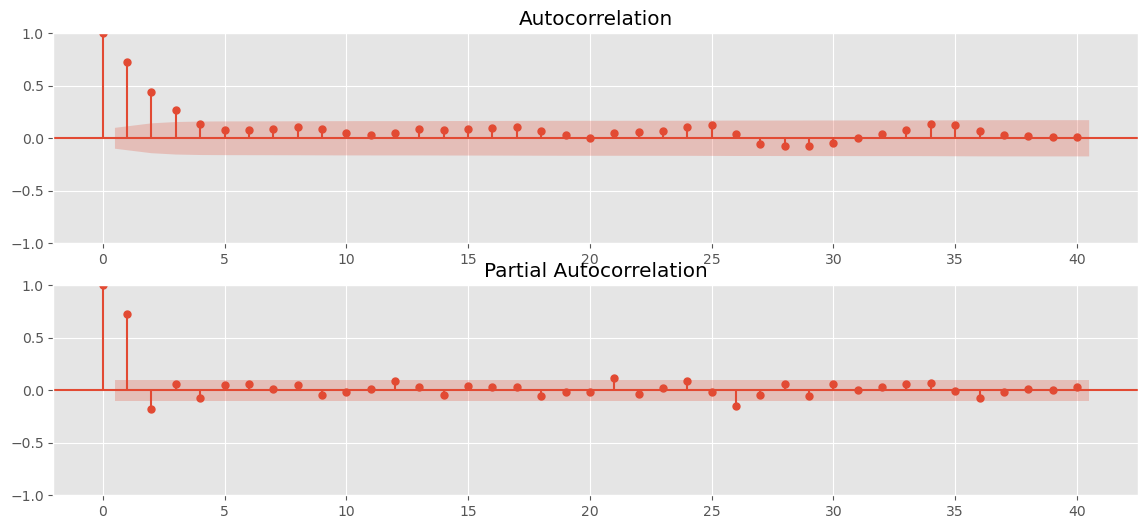

In [51]:
# Create a figure with two subplots (Autocorrelation and Partial Autocorrelation)
fig = plt.figure(figsize=(14,6))

# Autocorrelation plot
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_resampled['CO(GT)'].dropna(),lags=40,ax=ax1)

# Partial Autocorrelation plot
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_resampled['CO(GT)'].dropna(),lags=40,ax=ax2)

In [52]:
# Fit a Seasonal AutoRegressive Integrated Moving Average (SARIMA) model to the 'CO(GT)' time series
sarima_model = SARIMAX(df_resampled['CO(GT)'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(dis=-1)
print(sarima_model.summary())

C:\Users\prajn\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                             CO(GT)   No. Observations:                  389
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1995.481
Date:                            Sun, 19 Nov 2023   AIC                           4000.963
Time:                                    17:14:49   BIC                           4020.610
Sample:                                03-12-2004   HQIC                          4008.762
                                     - 04-04-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7064      0.037     18.874      0.000       0.633       0.780
ma.L1         -0.9826      0.022   

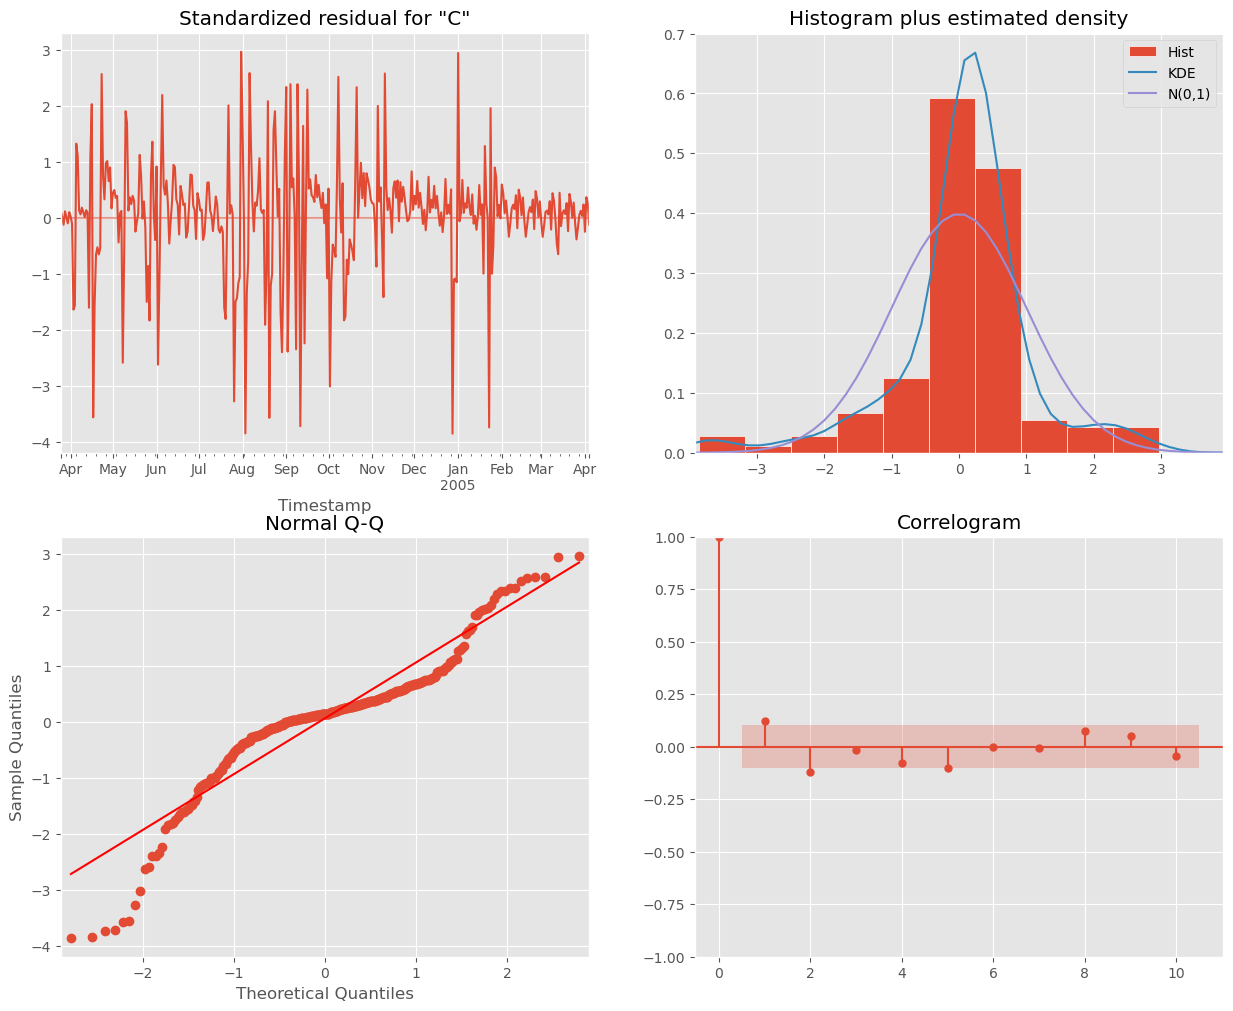

In [54]:
# plotting disagnostics for the sarima model we fitted
sarima_model.plot_diagnostics(figsize=(15,12));

In [55]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Extract the 'CO(GT)' column from df_resampled and scale the values between 0 and 1
scaled_data = scaler.fit_transform(df_resampled[['CO(GT)']])

# The 'scaled_data' now contains the normalized values of 'CO(GT)' using Min-Max scaling

In [56]:
# Split the scaled_data into training and testing sets
# test_size=0.2 means 80% of the data will be used for training and 20% for testing
# shuffle=False ensures that the split is done sequentially without shuffling the data
train, test = train_test_split(scaled_data, test_size=0.2, shuffle=False)

# Separate the input features (train_X) and the target variable (train_y)
# Here, train_X consists of all values except the last one, and train_y consists of all values starting from the second one
train_X, train_y = train[:-1], train[1:]

# Reshape the training data to be in the format (samples, time steps, features)
# LSTM models in Keras expect input data to be in this format
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

In [57]:
# Get a forecast using the SARIMA model for the test set
sarima_forecast = sarima_model.get_forecast(steps=len(test))

# Extract the predicted mean values from the forecast
predictions = sarima_forecast.predicted_mean

# Calculate metrics
mae = mean_absolute_error(test, predictions)
rmse = sqrt(mean_squared_error(test, predictions))

# Print or use the metrics as needed
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

Mean Absolute Error (MAE): 10.2462
Root Mean Squared Error (RMSE): 12.1228


In [58]:
# Create an LSTM model using Keras Sequential API
lstm_model = Sequential()

# Add an LSTM layer with 50 units and input shape defined by the training data dimensions
lstm_model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))

# Add a Dense layer with 1 unit for the output
lstm_model.add(Dense(1))

# Compile the LSTM model with Adam optimizer and mean squared error (MSE) loss
lstm_model.compile(optimizer='adam', loss='mse')

# Train the LSTM model on the training data
lstm_model.fit(train_X, train_y, epochs=50, batch_size=16, verbose=2)



Epoch 1/50

20/20 - 2s - loss: 0.6333 - 2s/epoch - 114ms/step
Epoch 2/50
20/20 - 0s - loss: 0.4578 - 60ms/epoch - 3ms/step
Epoch 3/50
20/20 - 0s - loss: 0.3052 - 53ms/epoch - 3ms/step
Epoch 4/50
20/20 - 0s - loss: 0.1838 - 56ms/epoch - 3ms/step
Epoch 5/50
20/20 - 0s - loss: 0.1054 - 55ms/epoch - 3ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0734 - 66ms/epoch - 3ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0654 - 65ms/epoch - 3ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0647 - 73ms/epoch - 4ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0643 - 73ms/epoch - 4ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0640 - 78ms/epoch - 4ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0636 - 66ms/epoch - 3ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0633 - 69ms/epoch - 3ms/step
Epoch 13/50
20/20 - 0s - loss: 0.0629 - 66ms/epoch - 3ms/step
Epoch 14/50
20/20 - 0s - loss: 0.0625 - 79ms/epoch - 4ms/step
Epoch 15/50
20/20 - 0s - loss: 0.0623 - 67ms/epoch - 3ms/step
Epoch 16/50
20/20 - 0s - loss: 0.0620 - 69ms/epoch - 3ms/step
Epoch 17/50
20

In [59]:
# Split the scaled test data into input (test_X) and output (test_y)
test_X, test_y = test[:-1], test[1:]

# Reshape the test input data to match the LSTM model's input shape
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Make predictions using the trained LSTM model on the test input data
lstm_predictions = lstm_model.predict(test_X, batch_size=16)

# Inverse transform the scaled predictions to the original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))

5/5 [==============================] - 1s 5ms/step


In [60]:
actual_values = df_resampled['CO(GT)'].iloc[-len(test) :]

mae = mean_absolute_error(test, predictions)
rmse = sqrt(mean_squared_error(actual_values, predictions))

# Print or use the metrics as needed
print(f'LSTM Mean Absolute Error (MAE): {mae:.4f}')
print(f'LSTM Root Mean Squared Error (RMSE): {rmse:.4f}')

LSTM Mean Absolute Error (MAE): 10.2462
LSTM Root Mean Squared Error (RMSE): 29.0349


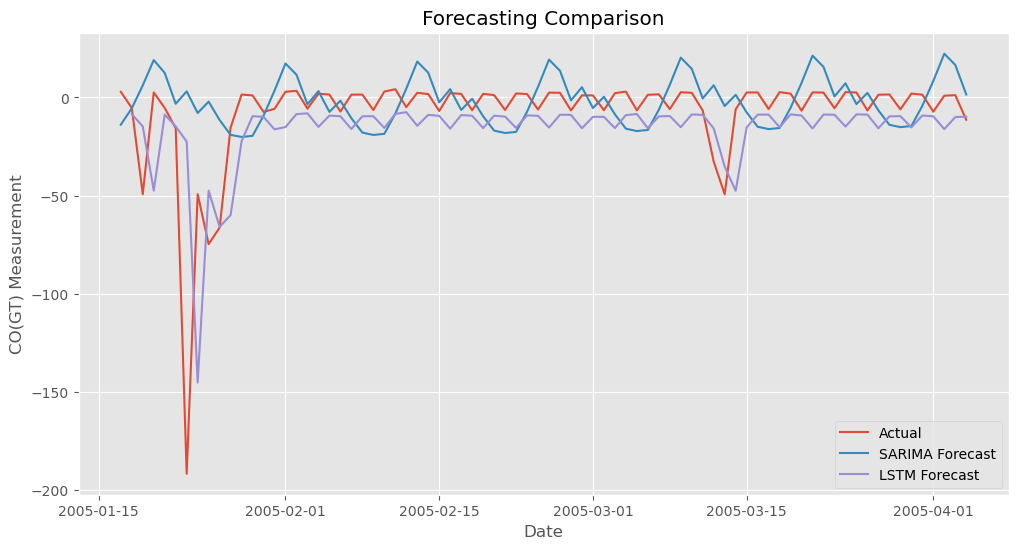

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index[-len(test):], df_resampled['CO(GT)'].iloc[-len(test):], label='Actual')
plt.plot(df_resampled.index[-len(test):], predictions, label='SARIMA Forecast')
plt.plot(df_resampled.index[-len(test):], np.concatenate([[np.nan], lstm_predictions.flatten()]), label='LSTM Forecast')
plt.title('Forecasting Comparison')
plt.xlabel('Date')
plt.ylabel('CO(GT) Measurement')
plt.legend()
plt.show()